In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/My Drive/yolo-v4-tf.keras')

In [3]:
import cv2
import numpy as np
from utils import DataGenerator, preprocess_true_boxes
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf
import math
from models import Yolov4, yolov4_head, get_boxes, nms
from config import yolo_config
from loss import *
print(tf.__version__)

2.2.0


In [4]:
with open('/content/drive/My Drive/yolo-v4-tf.keras/dataset/train_txt/anno2.txt') as f:
# with open('/content/drive/My Drive/yolo-v4-tf.keras/dataset/train_txt/anno.txt') as f:
    lines = f.readlines()
lines = lines[:]
# lines = lines * 8
print(lines)
# lines = lines * 32

NUM_CLASS = 3
FOLDER_PATH = '/content/drive/My Drive/yolo-v4-tf.keras'
BS = 8
anchors = np.array([12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401]).reshape((-1, 2))

data_gen = DataGenerator(lines[:], BS, (416, 416), num_classes=NUM_CLASS, folder_path=FOLDER_PATH, anchors=anchors)
model = Yolov4(
                weight_path=None,
                class_name_path='/content/drive/My Drive/yolo-v4-tf.keras/bccd_classes.txt'
            #    class_name_path='/content/drive/My Drive/yolo-v4-tf.keras/coco_classes.txt',
#               weight_path='yolov4.weights',
#                img_size=(416, 416, 3),
              )
model.build_model(load_pretrained=False)

print('num class : ', model.num_classes)

# model2 = tf.keras.models.load_model('/content/drive/My Drive/bccd.h5', compile=False)
# model.yolo_model = 
# yolov4_output = yolov4_head(self.yolo_model.output, self.num_classes, self.anchors, self.xyscale)
# self.inference_model = models.Model(self.yolo_model.input,
#                                     nms(yolov4_output, self.img_size, self.num_classes))  # [boxes, scores, classes, valid_detections]

['dataset/train_img/BloodImage_00000.jpg 260,177,491,376,0 78,336,184,435,2 63,237,169,336,2 214,362,320,461,2 414,352,506,445,2 555,356,640,455,2 469,412,567,480,2 1,333,87,437,2 4,406,95,480,2 155,74,247,174,2 11,84,104,162,2 534,39,639,139,2 547,195,640,295,2 388,11,481,111,2 171,175,264,275,2 260,1,374,83,2 229,91,343,174,2 69,144,184,235,2 482,131,594,230,2 368,89,464,176,2\n', 'dataset/train_img/BloodImage_00001.jpg 68,315,286,480,0 346,361,446,454,2 53,179,146,299,2 449,400,536,480,2 461,132,548,212,2 454,295,541,375,2 417,283,508,383,2 278,342,369,451,2 545,62,636,159,2 485,91,576,188,2 376,171,438,253,2 329,177,395,271,2 291,59,407,168,2 299,1,404,68,2 346,26,449,138,2 134,1,241,95,2 1,38,98,164,2 165,160,257,264,2 464,209,566,319,2\n', 'dataset/train_img/BloodImage_00002.jpg 385,98,523,198,2 384,164,499,260,2 101,120,224,222,2 130,344,234,443,2 161,381,254,480,2 14,228,123,344,2 306,293,415,409,2 531,103,632,221,2 492,233,593,347,2 364,261,465,375,2 264,60,365,174,2 249,174,3

In [6]:
model.yolo_model.load_weights('/content/drive/My Drive/yolo-v4-tf.keras/bccd.h5', by_name=True)

In [8]:
y_true = [
    tf.keras.layers.Input(name='input_2', shape=(52, 52, 3, (NUM_CLASS + 5))),  # label_sbbox
    tf.keras.layers.Input(name='input_3', shape=(26, 26, 3, (NUM_CLASS + 5))),  # label_mbbox
    tf.keras.layers.Input(name='input_4', shape=(13, 13, 3, (NUM_CLASS + 5))),  # label_lbbox
    tf.keras.layers.Input(name='input_5', shape=(100, 4)),             # true_bboxes
]
loss_list = tf.keras.layers.Lambda(yolo_loss, name='yolo_loss',
                        arguments={'num_classes': NUM_CLASS, 'iou_loss_thresh': 0.5,
                                    'anchors': anchors.reshape((3, 3, 2))})([*model.yolo_model.output, *y_true])
model2 = tf.keras.models.Model([model.yolo_model.input, *y_true], loss_list)

model2.compile(loss={'yolo_loss': lambda y_true, y_pred: y_pred}, optimizer=tf.keras.optimizers.Adam(lr=1e-3))
logs = np.array([])

In [ ]:
model2.fit(data_gen, 
           epochs=1000, initial_epoch=32,
            callbacks=[tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/bccd.h5', save_best_only=True, save_weights_only=False, monitor='loss')],
           )
# for epoch in range(50):
#     for x_batch, y_batch_tensor, y_batch_bbox in data_gen:
#         y_true = [np.zeros(BS)]
#         # print('train on batch ', y_batch_tensor[0].shape)
#         losses = model2.train_on_batch([x_batch, *y_batch_tensor, y_batch_bbox], y_true)
#         loss = losses
# #         if len(logs) > 0 and loss < np.min(logs):
# #             model.yolo_model.save('/content/drive/My Drive/yolov4-giou.h5')
#         logs = np.append(logs, loss)
#     print(f'epoch {epoch} losses ' , logs[-1])
#         # train_step(x_batch, y_batch_tensor, y_batch_bbox)

Epoch 33/1000
46/46 [==============================] - 70s 2s/step - loss: 108.7287
Epoch 34/1000
46/46 [==============================] - 68s 1s/step - loss: 81.3668
Epoch 35/1000
46/46 [==============================] - 67s 1s/step - loss: 69.4386
Epoch 36/1000
46/46 [==============================] - 67s 1s/step - loss: 59.3666
Epoch 37/1000
46/46 [==============================] - 68s 1s/step - loss: 53.3434
Epoch 38/1000
46/46 [==============================] - 68s 1s/step - loss: 50.6918
Epoch 39/1000
46/46 [==============================] - 68s 1s/step - loss: 49.2675
Epoch 40/1000
46/46 [==============================] - 67s 1s/step - loss: 47.6252
Epoch 41/1000
46/46 [==============================] - 67s 1s/step - loss: 46.9147
Epoch 42/1000
46/46 [==============================] - 67s 1s/step - loss: 46.5730
Epoch 43/1000
46/46 [==============================] - 68s 1s/step - loss: 45.5564
Epoch 44/1000
46/46 [==============================] - 67s 1s/step - loss: 45.1387
Epo

In [ ]:
# model.yolo_model.save('loss125.h5')

In [9]:
x_batch, y_true = data_gen.__getitem__(0)
# y_true = [np.zeros(BS), np.zeros(BS), np.zeros(BS)]
# y_true = [np.zeros(BS)]
# loss = model2.predict([x_batch, *y_batch_tensor, y_batch_bbox])
loss2 = model2.evaluate(x_batch, y_true)
print(loss2)

1/1 [==============================] - 0s 2ms/step - loss: 461.3955
461.3955383300781


In [ ]:
model.predict('/content/drive/My Drive/yolo-v4-tf.keras/dataset/train_img2/test3.jpg')

NameError: ignored

/content/drive/My Drive/yolo-v4-tf.keras/dataset/train_img/BloodImage_00018.jpg
img shape:  (480, 640, 3)
nms iou: 0.6 score: 0.1
# of bboxes: 16


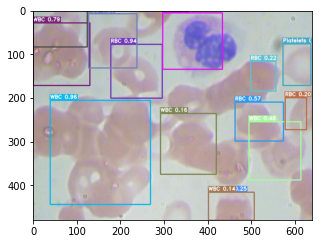

,x1,y1,x2,y2,class_name,score,w,h
0,39,206,269,444,WBC,0.964788,230,238
1,178,78,296,201,RBC,0.938469,118,123
2,0,0,124,84,RBC,0.869789,124,84
3,0,29,130,172,WBC,0.787741,130,143
4,463,210,574,299,RBC,0.566140,111,89
5,495,255,614,388,WBC,0.479953,119,133
6,578,200,627,273,Platelets,0.462415,49,73
7,127,8,238,132,RBC,0.282668,111,124
8,402,416,507,480,Platelets,0.248275,105,64
9,297,6,434,135,RBC,0.235680,137,129


In [10]:
i = np.random.randint(len(lines))
path = '/content/drive/My Drive/yolo-v4-tf.keras/' + lines[i].split(' ')[0] # f'/content/drive/My Drive/yolo-v4-tf.keras/dataset/train_img/BloodImage_00372.jpg'
print(path)
# model.predict(path)
model.predict_nonms(path, iou_threshold=0.6, score_threshold=0.1)

In [ ]:
#!/usr/bin/env python
# coding: utf-8



import cv2
import numpy as np
from utils import DataGenerator, preprocess_true_boxes
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf
import math

from models import Yolov4, yolov4_head, get_boxes
from config import yolo_config

print(tf.__version__)
# In[3]:


# with open('/content/drive/My Drive/yolo-v4-tf.keras/dataset/train_txt/anno2.txt') as f:
with open('/content/drive/My Drive/yolo-v4-tf.keras/dataset/train_txt/anno.txt') as f:
    lines = f.readlines()
lines = lines[:1]
# lines = lines * 8
print(lines)
# lines = lines * 32

# In[4]:

NUM_CLASS = 80
FOLDER_PATH = '/content/drive/My Drive/yolo-v4-tf.keras'
BS = 1
anchors = np.array([12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401]).reshape((-1, 2))


# In[6]:


data_gen = DataGenerator(lines[:], BS, (416, 416), num_classes=NUM_CLASS, folder_path=FOLDER_PATH, anchors=anchors)



model = Yolov4(
                weight_path=None,
                # class_name_path='/content/drive/My Drive/yolo-v4-tf.keras/bccd_classes.txt'
               class_name_path='/content/drive/My Drive/yolo-v4-tf.keras/coco_classes.txt',
#               weight_path='yolov4.weights',

#                img_size=(416, 416, 3),
            
              )
model.build_model(load_pretrained=False)
# model.load_model('/content/drive/My Drive/yolov4-giou.h5')
print('num class : ', model.num_classes)



# In[29]:


# from tflite yolov4
def bbox_giou(bboxes1, bboxes2):
    """
    Generalized IoU
    @param bboxes1: (a, b, ..., 4)
    @param bboxes2: (A, B, ..., 4)
        x:X is 1:n or n:n or n:1
    @return (max(a,A), max(b,B), ...)
    ex) (4,):(3,4) -> (3,)
        (2,1,4):(2,3,4) -> (2,3)
    """
    bboxes1_area = bboxes1[..., 2] * bboxes1[..., 3]
    bboxes2_area = bboxes2[..., 2] * bboxes2[..., 3]

    bboxes1_coor = tf.concat(
        [
            bboxes1[..., :2] - bboxes1[..., 2:] * 0.5,
            bboxes1[..., :2] + bboxes1[..., 2:] * 0.5,
        ],
        axis=-1,
    )
    bboxes2_coor = tf.concat(
        [
            bboxes2[..., :2] - bboxes2[..., 2:] * 0.5,
            bboxes2[..., :2] + bboxes2[..., 2:] * 0.5,
        ],
        axis=-1,
    )

    left_up = tf.maximum(bboxes1_coor[..., :2], bboxes2_coor[..., :2])
    right_down = tf.minimum(bboxes1_coor[..., 2:], bboxes2_coor[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]

    union_area = bboxes1_area + bboxes2_area - inter_area

    iou = tf.math.divide_no_nan(inter_area, union_area)

    enclose_left_up = tf.minimum(bboxes1_coor[..., :2], bboxes2_coor[..., :2])
    enclose_right_down = tf.maximum(
        bboxes1_coor[..., 2:], bboxes2_coor[..., 2:]
    )

    enclose_section = enclose_right_down - enclose_left_up
    enclose_area = enclose_section[..., 0] * enclose_section[..., 1]

    giou = iou - tf.math.divide_no_nan(enclose_area - union_area, enclose_area)

    return giou
def bbox_ciou(boxes1, boxes2):
    '''
    计算ciou = iou - p2/c2 - av
    :param boxes1: (8, 13, 13, 3, 4)   pred_xywh
    :param boxes2: (8, 13, 13, 3, 4)   label_xywh
    :return:

    举例时假设pred_xywh和label_xywh的shape都是(1, 4)
    '''

    # 变成左上角坐标、右下角坐标
    boxes1_x0y0x1y1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                                 boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2_x0y0x1y1 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                                 boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)
    '''
    逐个位置比较boxes1_x0y0x1y1[..., :2]和boxes1_x0y0x1y1[..., 2:]，即逐个位置比较[x0, y0]和[x1, y1]，小的留下。
    比如留下了[x0, y0]
    这一步是为了避免一开始w h 是负数，导致x0y0成了右下角坐标，x1y1成了左上角坐标。
    '''
    boxes1_x0y0x1y1 = tf.concat([tf.minimum(boxes1_x0y0x1y1[..., :2], boxes1_x0y0x1y1[..., 2:]),
                                 tf.maximum(boxes1_x0y0x1y1[..., :2], boxes1_x0y0x1y1[..., 2:])], axis=-1)
    boxes2_x0y0x1y1 = tf.concat([tf.minimum(boxes2_x0y0x1y1[..., :2], boxes2_x0y0x1y1[..., 2:]),
                                 tf.maximum(boxes2_x0y0x1y1[..., :2], boxes2_x0y0x1y1[..., 2:])], axis=-1)

    # 两个矩形的面积
    boxes1_area = (boxes1_x0y0x1y1[..., 2] - boxes1_x0y0x1y1[..., 0]) * (
                boxes1_x0y0x1y1[..., 3] - boxes1_x0y0x1y1[..., 1])
    boxes2_area = (boxes2_x0y0x1y1[..., 2] - boxes2_x0y0x1y1[..., 0]) * (
                boxes2_x0y0x1y1[..., 3] - boxes2_x0y0x1y1[..., 1])

    # 相交矩形的左上角坐标、右下角坐标，shape 都是 (8, 13, 13, 3, 2)
    left_up = tf.maximum(boxes1_x0y0x1y1[..., :2], boxes2_x0y0x1y1[..., :2])
    right_down = tf.minimum(boxes1_x0y0x1y1[..., 2:], boxes2_x0y0x1y1[..., 2:])

    # 相交矩形的面积inter_area。iou
    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area
    iou = inter_area / (union_area + 1e-9)

    # 包围矩形的左上角坐标、右下角坐标，shape 都是 (8, 13, 13, 3, 2)
    enclose_left_up = tf.minimum(boxes1_x0y0x1y1[..., :2], boxes2_x0y0x1y1[..., :2])
    enclose_right_down = tf.maximum(boxes1_x0y0x1y1[..., 2:], boxes2_x0y0x1y1[..., 2:])

    # 包围矩形的对角线的平方
    enclose_wh = enclose_right_down - enclose_left_up
    enclose_c2 = K.pow(enclose_wh[..., 0], 2) + K.pow(enclose_wh[..., 1], 2)

    # 两矩形中心点距离的平方
    p2 = K.pow(boxes1[..., 0] - boxes2[..., 0], 2) + K.pow(boxes1[..., 1] - boxes2[..., 1], 2)

    # 增加av。加上除0保护防止nan。
    atan1 = tf.atan(boxes1[..., 2] / (boxes1[..., 3] + 1e-9))
    atan2 = tf.atan(boxes2[..., 2] / (boxes2[..., 3] + 1e-9))
    v = 4.0 * K.pow(atan1 - atan2, 2) / (math.pi ** 2)
    a = v / (1 - iou + v)

    ciou = iou - 1.0 * p2 / enclose_c2 - 1.0 * a * v
    return ciou
def bbox_iou(boxes1, boxes2):
    boxes1_area = boxes1[..., 2] * boxes1[..., 3]  # 所有格子的3个预测框的面积
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]  # 所有ground truth的面积

    # (x, y, w, h)变成(x0, y0, x1, y1)
    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    # 所有格子的3个预测框 分别 和  70个ground truth  计算iou。 所以left_up和right_down的shape = (?, grid_h, grid_w, 3, 70, 2)
    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])  # 相交矩形的左上角坐标
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])  # 相交矩形的右下角坐标

    inter_section = tf.maximum(right_down - left_up, 0.0)  # 相交矩形的w和h，是负数时取0     (?, grid_h, grid_w, 3, 70, 2)
    inter_area = inter_section[..., 0] * inter_section[..., 1]  # 相交矩形的面积            (?, grid_h, grid_w, 3, 70)
    union_area = boxes1_area + boxes2_area - inter_area  # union_area      (?, grid_h, grid_w, 3, 70)
    iou = 1.0 * inter_area / (union_area + 1e-9)  # iou                             (?, grid_h, grid_w, 3, 70)
    return iou

def yolo_loss_wrapper(input_shape, STRIDES, NUM_CLASS, ANCHORS, XYSCALES, IOU_LOSS_THRESH):
    input_shape = input_shape[0]
    def yolo_loss(label, y_pred, y_batch_box):
        bboxes = decode_train2(y_pred, input_shape // STRIDES, NUM_CLASS, STRIDES, ANCHORS, XYSCALES)
        
        conv_shape = tf.shape(y_pred)
        batch_size = conv_shape[0]
        output_size = conv_shape[1]
        input_size = STRIDES * output_size
        # conv = tf.reshape(conv, (batch_size, output_size, output_size,
        #                          3, 5 + num_class))
        conv_raw_prob = bboxes[:, :, :, :, 5:]

        pred_xywh = bboxes[:, :, :, :, 0:4]
        pred_conf = bboxes[:, :, :, :, 4:5]

        label_xywh = label[:, :, :, :, 0:4]
        respond_bbox = label[:, :, :, :, 4:5]
        label_prob = label[:, :, :, :, 5:]

        ciou = tf.expand_dims(bbox_giou(pred_xywh, label_xywh), axis=-1)  # (8, 13, 13, 3, 1)
        # ciou = tf.expand_dims(bbox_ciou(pred_xywh, label_xywh), axis=-1)  # (8, 13, 13, 3, 1)
        input_size = tf.cast(input_size, tf.float32)

        # 每个预测框xxxiou_loss的权重 = 2 - (ground truth的面积/图片面积)
        bbox_loss_scale = 2.0 - 1.0 * label_xywh[:, :, :, :, 2:3] * label_xywh[:, :, :, :, 3:4] / (input_size ** 2)
        ciou_loss = respond_bbox * bbox_loss_scale * (1 - ciou)  # 1. respond_bbox作为mask，有物体才计算xxxiou_loss

        # 2. respond_bbox作为mask，有物体才计算类别loss
        prob_loss = respond_bbox *  tf.nn.sigmoid_cross_entropy_with_logits(label_prob, conv_raw_prob)
        # 等价于
        # pred_prob = pred[:, :, :, :, 5:]
        # prob_pos_loss = label_prob * (0 - K.log(pred_prob + 1e-9))
        # prob_neg_loss = (1 - label_prob) * (0 - K.log(1 - pred_prob + 1e-9))
        # prob_mask = tf.tile(respond_bbox, [1, 1, 1, 1, num_class])
        # prob_loss = prob_mask * (prob_pos_loss + prob_neg_loss)

        # 3. xxxiou_loss和类别loss比较简单。重要的是conf_loss，是一个二值交叉熵损失
        # 分两步：第一步是确定 grid_h * grid_w * 3 个预测框 哪些作为反例；第二步是计算二值交叉熵损失。
        expand_pred_xywh = pred_xywh[:, :, :, :, np.newaxis, :]  # 扩展为(?, grid_h, grid_w, 3,   1, 4)
        expand_bboxes = y_batch_bbox[:, np.newaxis, np.newaxis, np.newaxis, :, :]  # 扩展为(?,      1,      1, 1, 70, 4)
        iou = bbox_iou(expand_pred_xywh,
                       expand_bboxes)  # 所有格子的3个预测框 分别 和  70个ground truth  计算iou。   (?, grid_h, grid_w, 3, 70)
        max_iou = tf.expand_dims(tf.reduce_max(iou, axis=-1),
                                 axis=-1)  # 与70个ground truth的iou中，保留最大那个iou。  (?, grid_h, grid_w, 3, 1)

        # respond_bgd代表  这个分支输出的 grid_h * grid_w * 3 个预测框是否是 反例（背景）
        # label有物体，respond_bgd是0。 没物体的话：如果和某个gt(共70个)的iou超过iou_loss_thresh，respond_bgd是0；如果和所有gt(最多70个)的iou都小于iou_loss_thresh，respond_bgd是1。
        # respond_bgd是0代表有物体，不是反例（或者是忽略框）；  权重respond_bgd是1代表没有物体，是反例。
        # 有趣的是，模型训练时由于不断更新，对于同一张图片，两次预测的 grid_h * grid_w * 3 个预测框（对于这个分支输出）  是不同的。用的是这些预测框来与gt计算iou来确定哪些预测框是反例。
        # 而不是用固定大小（不固定位置）的先验框。
        respond_bgd = (1.0 - respond_bbox) * tf.cast(max_iou < IOU_LOSS_THRESH, tf.float32)

        # 二值交叉熵损失
        pos_loss = respond_bbox * (0 - K.log(pred_conf + 1e-9))
        neg_loss = respond_bgd * (0 - K.log(1 - pred_conf + 1e-9))

        conf_loss = pos_loss + neg_loss
        # 回顾respond_bgd，某个预测框和某个gt的iou超过iou_loss_thresh，不被当作是反例。在参与“预测的置信位 和 真实置信位 的 二值交叉熵”时，这个框也可能不是正例(label里没标这个框是1的话)。这个框有可能不参与置信度loss的计算。
        # 这种框一般是gt框附近的框，或者是gt框所在格子的另外两个框。它既不是正例也不是反例不参与置信度loss的计算。（论文里称之为ignore）

        ciou_loss = tf.reduce_mean(tf.reduce_sum(ciou_loss, axis=[1, 2, 3, 4]))  # 每个样本单独计算自己的ciou_loss，再求平均值
        conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1, 2, 3, 4]))  # 每个样本单独计算自己的conf_loss，再求平均值
        prob_loss = tf.reduce_mean(tf.reduce_sum(prob_loss, axis=[1, 2, 3, 4]))  # 每个样本单独计算自己的prob_loss，再求平均值

        return ciou_loss, conf_loss, prob_loss    

    return yolo_loss
def decode(conv_output, anchors, stride, num_class):
    conv_shape       = tf.shape(conv_output)
    batch_size       = conv_shape[0]
    output_size      = conv_shape[1]
    anchor_per_scale = len(anchors)
    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, anchor_per_scale, 5 + num_class))
    conv_raw_dxdy = conv_output[:, :, :, :, 0:2]
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4]
    conv_raw_conf = conv_output[:, :, :, :, 4:5]
    conv_raw_prob = conv_output[:, :, :, :, 5: ]
    y = tf.tile(tf.range(output_size, dtype=tf.int32)[:, tf.newaxis], [1, output_size])
    x = tf.tile(tf.range(output_size, dtype=tf.int32)[tf.newaxis, :], [output_size, 1])
    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, anchor_per_scale, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)
    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * stride
    pred_wh = (tf.exp(conv_raw_dwdh) * anchors)
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)
    pred_conf = tf.sigmoid(conv_raw_conf)
    pred_prob = tf.sigmoid(conv_raw_prob)
    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)
def loss_layer(conv, pred, label, bboxes, stride, num_class, iou_loss_thresh):
    conv_shape = tf.shape(conv)
    batch_size = conv_shape[0]
    output_size = conv_shape[1]
    input_size = stride * output_size
    conv = tf.reshape(conv, (batch_size, output_size, output_size,
                             3, 5 + num_class))
    conv_raw_prob = conv[:, :, :, :, 5:]

    pred_xywh = pred[:, :, :, :, 0:4]
    pred_conf = pred[:, :, :, :, 4:5]

    label_xywh = label[:, :, :, :, 0:4]
    respond_bbox = label[:, :, :, :, 4:5]
    label_prob = label[:, :, :, :, 5:]

    ciou = tf.expand_dims(bbox_ciou(pred_xywh, label_xywh), axis=-1)  # (8, 13, 13, 3, 1)
    input_size = tf.cast(input_size, tf.float32)

    # 每个预测框xxxiou_loss的权重 = 2 - (ground truth的面积/图片面积)
    bbox_loss_scale = 2.0 - 1.0 * label_xywh[:, :, :, :, 2:3] * label_xywh[:, :, :, :, 3:4] / (input_size ** 2)
    ciou_loss = respond_bbox * bbox_loss_scale * (1 - ciou)  # 1. respond_bbox作为mask，有物体才计算xxxiou_loss

    # 2. respond_bbox作为mask，有物体才计算类别loss
    prob_loss = respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=label_prob, logits=conv_raw_prob)
    # 等价于
    # pred_prob = pred[:, :, :, :, 5:]
    # prob_pos_loss = label_prob * (0 - K.log(pred_prob + 1e-9))
    # prob_neg_loss = (1 - label_prob) * (0 - K.log(1 - pred_prob + 1e-9))
    # prob_mask = tf.tile(respond_bbox, [1, 1, 1, 1, num_class])
    # prob_loss = prob_mask * (prob_pos_loss + prob_neg_loss)


    # 3. xxxiou_loss和类别loss比较简单。重要的是conf_loss，是一个二值交叉熵损失
    # 分两步：第一步是确定 grid_h * grid_w * 3 个预测框 哪些作为反例；第二步是计算二值交叉熵损失。
    expand_pred_xywh = pred_xywh[:, :, :, :, np.newaxis, :]  # 扩展为(?, grid_h, grid_w, 3,   1, 4)
    expand_bboxes = bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :]  # 扩展为(?,      1,      1, 1, 70, 4)
    iou = bbox_iou(expand_pred_xywh, expand_bboxes)  # 所有格子的3个预测框 分别 和  70个ground truth  计算iou。   (?, grid_h, grid_w, 3, 70)
    max_iou = tf.expand_dims(tf.reduce_max(iou, axis=-1), axis=-1)  # 与70个ground truth的iou中，保留最大那个iou。  (?, grid_h, grid_w, 3, 1)

    # respond_bgd代表  这个分支输出的 grid_h * grid_w * 3 个预测框是否是 反例（背景）
    # label有物体，respond_bgd是0。 没物体的话：如果和某个gt(共70个)的iou超过iou_loss_thresh，respond_bgd是0；如果和所有gt(最多70个)的iou都小于iou_loss_thresh，respond_bgd是1。
    # respond_bgd是0代表有物体，不是反例（或者是忽略框）；  权重respond_bgd是1代表没有物体，是反例。
    # 有趣的是，模型训练时由于不断更新，对于同一张图片，两次预测的 grid_h * grid_w * 3 个预测框（对于这个分支输出）  是不同的。用的是这些预测框来与gt计算iou来确定哪些预测框是反例。
    # 而不是用固定大小（不固定位置）的先验框。
    # respond_bgd = (1.0 - respond_bbox) * tf.cast(max_iou < iou_loss_thresh, tf.float32)
    respond_bgd = (1.0 - respond_bbox)

    # 二值交叉熵损失
    pos_loss = respond_bbox * (0 - K.log(pred_conf + 1e-9))
    neg_loss = respond_bgd  * (0 - K.log(1 - pred_conf + 1e-9))

    conf_loss = pos_loss + neg_loss
    # 回顾respond_bgd，某个预测框和某个gt的iou超过iou_loss_thresh，不被当作是反例。在参与“预测的置信位 和 真实置信位 的 二值交叉熵”时，这个框也可能不是正例(label里没标这个框是1的话)。这个框有可能不参与置信度loss的计算。
    # 这种框一般是gt框附近的框，或者是gt框所在格子的另外两个框。它既不是正例也不是反例不参与置信度loss的计算。（论文里称之为ignore）

    ciou_loss = tf.reduce_mean(tf.reduce_sum(ciou_loss, axis=[1, 2, 3, 4]))  # 每个样本单独计算自己的ciou_loss，再求平均值
    conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1, 2, 3, 4]))  # 每个样本单独计算自己的conf_loss，再求平均值
    prob_loss = tf.reduce_mean(tf.reduce_sum(prob_loss, axis=[1, 2, 3, 4]))  # 每个样本单独计算自己的prob_loss，再求平均值

    return ciou_loss, conf_loss, prob_loss

def decode_train2(conv_output, output_size, NUM_CLASS, STRIDES, ANCHORS, XYSCALE):
    conv_output = tf.reshape(conv_output,
                             (tf.shape(conv_output)[0], output_size, output_size, 3, 5 + NUM_CLASS))

    # conv_raw_dxdy, conv_raw_dwdh, conv_raw_conf, conv_raw_prob = tf.split(conv_output, (2, 2, 1, NUM_CLASS),
    #                                                                       axis=-1)
    conv_raw_dxdy = conv_output[:, :, :, :, 0:2]
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4]
    conv_raw_conf = conv_output[:, :, :, :, 4:5]
    conv_raw_prob = conv_output[:, :, :, :, 5:]

    # xy_grid = tf.meshgrid(tf.range(output_size), tf.range(output_size))
    # xy_grid = tf.expand_dims(tf.stack(xy_grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
    # xy_grid = tf.tile(tf.expand_dims(xy_grid, axis=0), [tf.shape(conv_output)[0], 1, 1, 3, 1])
    # xy_grid = tf.cast(xy_grid, tf.float32)
    y = tf.tile(tf.range(output_size, dtype=tf.int32)[:, tf.newaxis], [1, output_size])
    x = tf.tile(tf.range(output_size, dtype=tf.int32)[tf.newaxis, :], [output_size, 1])
    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [tf.shape(conv_output)[0], 1, 1, 3, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)

    # pred_xy = ((tf.sigmoid(conv_raw_dxdy) * XYSCALE) - 0.5 * (XYSCALE - 1) + xy_grid) * STRIDES
    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * STRIDES
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS)
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)

    pred_conf = tf.sigmoid(conv_raw_conf)
    # pred_prob = tf.sigmoid(conv_raw_prob)

    return tf.concat([pred_xywh, pred_conf, conv_raw_prob], axis=-1)

# x_batch, y_batch = X, y = data_gen.__getitem__(0)


losses = [yolo_loss_wrapper(input_shape=(416, 416), 
                  STRIDES=[8, 16, 32][i], 
                  NUM_CLASS=NUM_CLASS,
                  ANCHORS=anchors.reshape(3, 3, 2)[i], 
                  XYSCALES=[1., 1., 1.][i], 
                  IOU_LOSS_THRESH=0.5) for i in range(3)]
def yolo_loss2(args, num_classes, iou_loss_thresh, anchors):
    conv_lbbox = args[2]   # (?, ?, ?, 3*(num_classes+5))
    conv_mbbox = args[1]   # (?, ?, ?, 3*(num_classes+5))
    conv_sbbox = args[0]   # (?, ?, ?, 3*(num_classes+5))
    label_sbbox = args[3]   # (?, ?, ?, 3, num_classes+5)
    label_mbbox = args[4]   # (?, ?, ?, 3, num_classes+5)
    label_lbbox = args[5]   # (?, ?, ?, 3, num_classes+5)
    true_bboxes = args[6]   # (?, 50, 4)
    pred_sbbox = decode(conv_sbbox, anchors[0], 8, num_classes)
    pred_mbbox = decode(conv_mbbox, anchors[1], 16, num_classes)
    pred_lbbox = decode(conv_lbbox, anchors[2], 32, num_classes)
    # pred_sbbox = decode_train2(conv_sbbox, 52, num_classes, 8, anchors[0], 1) # decode(conv_sbbox, anchors[0], 8, num_classes)
    # pred_mbbox = decode_train2(conv_mbbox, 26, num_classes, 16, anchors[1], 1) # decode(conv_mbbox, anchors[1], 16, num_classes)
    # pred_lbbox = decode_train2(conv_lbbox, 13, num_classes, 32, anchors[2], 1) # decode(conv_lbbox, anchors[2], 32, num_classes)
    sbbox_ciou_loss, sbbox_conf_loss, sbbox_prob_loss = loss_layer(conv_sbbox, pred_sbbox, label_sbbox, true_bboxes, 8, num_classes, iou_loss_thresh)
    mbbox_ciou_loss, mbbox_conf_loss, mbbox_prob_loss = loss_layer(conv_mbbox, pred_mbbox, label_mbbox, true_bboxes, 16, num_classes, iou_loss_thresh)
    lbbox_ciou_loss, lbbox_conf_loss, lbbox_prob_loss = loss_layer(conv_lbbox, pred_lbbox, label_lbbox, true_bboxes, 32, num_classes, iou_loss_thresh)

    ciou_loss = lbbox_ciou_loss + sbbox_ciou_loss + mbbox_ciou_loss
    conf_loss = lbbox_conf_loss + sbbox_conf_loss + mbbox_conf_loss
    prob_loss = lbbox_prob_loss + sbbox_prob_loss + mbbox_prob_loss
    # print(ciou_loss, conf_loss, prob_loss)
    return ciou_loss, conf_loss, prob_loss

# # In[31]:
INIT_LR = 1e-4 # 1e-6
FINAL_LR = 1e-4 # 1e-8
opt = tf.keras.optimizers.Adam(lr=1e-4)
opt2 = tf.keras.optimizers.Adam(lr=1e-4)
opt3 = tf.keras.optimizers.Adam(lr=1e-4)
steps_per_epoch = len(lines) // BS
warmup_epochs = 20
warmup_steps = warmup_epochs * steps_per_epoch
global_steps = 0
first_stage_epoch = 200
second_stage_epoch = 300
total_steps = (first_stage_epoch + second_stage_epoch) * steps_per_epoch

y_true = [
    tf.keras.layers.Input(name='input_2', shape=(52, 52, 3, (NUM_CLASS + 5))),  # label_sbbox
    tf.keras.layers.Input(name='input_3', shape=(26, 26, 3, (NUM_CLASS + 5))),  # label_mbbox
    tf.keras.layers.Input(name='input_4', shape=(13, 13, 3, (NUM_CLASS + 5))),  # label_lbbox
    tf.keras.layers.Input(name='input_5', shape=(100, 4)),             # true_bboxes
]
loss_list = tf.keras.layers.Lambda(yolo_loss2, name='yolo_loss',
                        arguments={'num_classes': NUM_CLASS, 'iou_loss_thresh': 0.5,
                                    'anchors': anchors.reshape((3, 3, 2))})([*model.yolo_model.output, *y_true])
model2 = tf.keras.models.Model([model.yolo_model.input, *y_true], loss_list)

model2.compile(loss={'yolo_loss': lambda y_true, y_pred: y_pred}, optimizer=tf.keras.optimizers.Adam(lr=1e-4))




In [ ]:
def train_step(x_batch, y_batch_tensor, y_batch_bbox):
    with tf.GradientTape() as tape_giou, tf.GradientTape() as tape_conf, tf.GradientTape() as tape_prob:
        predict = model.yolo_model(x_batch)
        # total_giou_loss = 0
        # total_conf_loss = 0
        # total_prob_loss = 0
        # for i in range(0,3):
        #     loss_func = losses[i]
        #     giou_loss, conf_loss, prob_loss = loss_func(y_batch_tensor[i], predict[i], y_batch_bbox)
        #     total_giou_loss += giou_loss
        #     total_conf_loss += conf_loss
        #     total_prob_loss += prob_loss
        #     print(i, total_giou_loss, total_conf_loss, total_prob_loss)

        giou_loss0, conf_loss0, prob_loss0 = losses[0](y_batch_tensor[0], predict[0], y_batch_bbox)
        giou_loss1, conf_loss1, prob_loss1 = losses[1](y_batch_tensor[1], predict[1], y_batch_bbox)
        giou_loss2, conf_loss2, prob_loss2 = losses[2](y_batch_tensor[2], predict[2], y_batch_bbox)
        total_giou_loss = giou_loss0 + giou_loss1 + giou_loss2
        total_conf_loss = conf_loss0 + conf_loss1 + conf_loss2
        total_prob_loss = prob_loss0 + prob_loss1 + prob_loss2
        print(total_giou_loss, total_conf_loss, total_prob_loss)
        # total_loss = total_giou_loss + total_conf_loss + total_prob_loss  # total_giou_loss + total_conf_loss + total_prob_loss
    gradients1 = tape_giou.gradient(total_giou_loss, model.yolo_model.trainable_variables)
    gradients2 = tape_conf.gradient(total_conf_loss, model.yolo_model.trainable_variables)
    gradients3 = tape_prob.gradient(total_prob_loss, model.yolo_model.trainable_variables)
    opt.apply_gradients(zip(gradients1, model.yolo_model.trainable_variables))
    opt2.apply_gradients(zip(gradients2, model.yolo_model.trainable_variables))
    opt3.apply_gradients(zip(gradients3, model.yolo_model.trainable_variables))

logs = np.array([])
for epoch in range(1000):
    for x_batch, y_batch_tensor, y_batch_bbox in data_gen:
        y_true = [np.zeros(BS), np.zeros(BS), np.zeros(BS)]
        # print('train on batch ', y_batch_tensor[0].shape)
        losses = model2.train_on_batch([x_batch, *y_batch_tensor, y_batch_bbox], y_true)
        loss = losses[0]
        print(f'epoch {epoch} losses ' , loss)
        if len(logs) > 0 and loss < np.min(logs):
            model.yolo_model.save('/content/drive/My Drive/yolov4-giou.h5')
        logs = np.append(logs, loss)
        # train_step(x_batch, y_batch_tensor, y_batch_bbox)

In [ ]:
# model2.fit(data_gen, 
#             steps_per_epoch=1,
#            epochs=10000
#            )

In [ ]:
model.predict('/content/drive/My Drive/yolo-v4-tf.keras/dataset/train_img2/test3.jpg')

In [ ]:
i = np.random.randint(0, 300)
path = f'/content/drive/My Drive/yolo-v4-tf.keras/dataset/train_img/BloodImage_00000.jpg'
print(path)
model.predict(path)